In [1]:

# Description -----------------------------------------------------------
# -----------------------------------------------------------------------

# Create a bell state
# Take any psi state and entangle it with one qubit of the bell pair
# Apply hadamard to the psi state
# Measure psi and its entangled partner
# As per the measurement, apply an unitary operation
#                         to the other qubit of the bell pair
# The other qubit of the bell pair is now the teleported psi state

# -----------------------------------------------------------------------



In [2]:

# Import matplot library
%matplotlib inline

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, extensions
from qiskit.compiler import transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import numpy for psi
import numpy as np

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Initializing a backend
backend = Aer.get_backend('qasm_simulator')


In [3]:

# To run the circuit
def run_circ(circ, backend):

    # Executing the previously constructed circuit on the backend
    job = execute(circ, backend, shots=1024)

    # Grabbing the results from the job.
    result = job.result()

    # Getting the output
    counts = result.get_counts(circ)
    print(counts)
    
    # Getting the snapshots
    snapshots = result.data()['snapshots']['statevector']
    
    # Return the snapshots
    return snapshots


In [4]:

# Treat the teleported state
def apply_unitary(circ, c0, c1):

    # if bits [0, 1] or [1, 1]
    circ.z(2).c_if(c0, 1)

    # if bits [1, 0] or [1, 1]
    circ.x(2).c_if(c1, 1)

    # Return the updated circuit
    return circ


In [5]:

# Entangle the psi with a bell state
def entangle_psi(circ, ctrl, trg):

    # Apply control to entangle the qubits
    circ.cx(ctrl, trg)
    
    # Apply Hadamard to Control qubit
    circ.h(ctrl)

    # Applying a barrier to isolate the bell state
    circ.barrier()
    
    # Return the updated circuit
    return circ
    

In [6]:

# Bell state: |Φ+⟩=1/√2(|00⟩+|11⟩
def create_bell(circ, ctrl, trg):

    # Apply the gates to create bell state
    circ.h(ctrl)
    circ.cx(ctrl, trg)

    # Applying a barrier to isolate the bell state
    circ.barrier()
    
    # Return the bell circuit
    return circ


In [7]:

# Initialize quantum circuit with state psi
def init_circ(init_gate):

    qr = QuantumRegister(3, name="q")
    c0 = ClassicalRegister(1, name="c0")
    c1 = ClassicalRegister(1, name="c1")
    circ = QuantumCircuit(qr, c0, c1)

    # Initialise first qubit to have state Psi
    circ.append(init_gate, [0])
    
    # Return the updated circuit with the classical bits
    return [circ, c0, c1]


In [8]:

# Create the psi state
def create_psi():

    # Psi as initialisation gate
    init_gate = extensions.Initialize(psi)
    init_gate.label = "Custom Gate"
    
    # Return the initialized gate
    return init_gate


In [9]:
# Teleportation Protocol:

def teleport_state(psi):

    # Initialize psi as a Quantum Gate
    init_gate = create_psi()
    
    # Initialize circuit with psi state
    circuit_elements = init_circ(init_gate)
    
    # Extract the returned data
    circ = circuit_elements[0]
    c0 = circuit_elements[1]
    c1 = circuit_elements[2]
    
    # Record the initial statevector
    circ.snapshot('1')

    # Create Bell pair
    circ = create_bell(circ, 1, 2)
    
    # Entangle psi
    circ = entangle_psi(circ, 0, 1)
    
    # Measure state and map to c_bits
    circ.measure([0, 1], [0, 1])
    circ.barrier()

    # Apply Unitary operation(s) (to get the desired state)
    circ = apply_unitary(circ, c0, c1)
    
    # Record the final statevector
    circ.snapshot('2')
    
    # Run circuit
    snapshots = run_circ(circ, backend)

    # Return the complete circuit and its snapshots
    return [circ, snapshots]


In [10]:

# Check whether the state has been teleported
def verify_state(snap1, snap2, psi):
    a = [c for c in snap1[0] if c != 0]
    b = [c for c in snap2[0] if c != 0]

    # Compare the states
    if np.round(a[0]+a[1], 5) == np.round(b[0]+ b[1], 5):
        return "State has been successfully teleported!"
    else:
        return "Error: Teleported state is corrupted!"


Enter the state of the qubit being 0: 0.5533920757991503+0.3043529040180291j
Enter the state of the qubit being 1: 0.6147796854942953+0.4724113234904887j
{'0 1': 271, '1 0': 243, '0 0': 228, '1 1': 282}


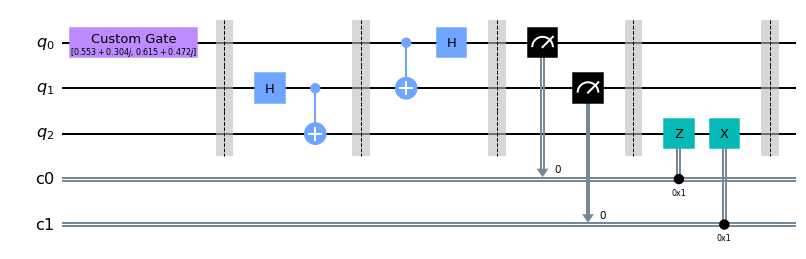

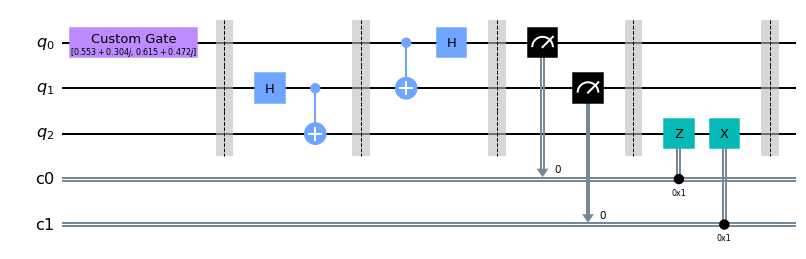

In [11]:

# Initializing the state to be teleported
state0 = complex(input("Enter the state of the qubit being 0: "))
state1 = complex(input("Enter the state of the qubit being 1: "))
# [0.5533920757991503+0.3043529040180291j,
# 0.6147796854942953+0.4724113234904887j]

psi = np.array(
    [
        state0,
        state1
    ]
)

# Teleportation
circ_n_state = teleport_state(psi)
circ = circ_n_state[0]
circ.draw()


In [12]:

# Check if it's the same state
snapshots = circ_n_state[1]
status = verify_state(snapshots['1'], snapshots['2'], psi)
print(status)


State has been successfully teleported!
